# Importing packages 

In [1]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

# Custom functions

In [2]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

# Reading the data 

In [3]:
d = pd.read_csv('data/weather.csv')

print(f'Shape of data: {d.shape}')

Shape of data: (294227, 25)


In [4]:
# Types of columns
d.dtypes

dt                       int64
dt_iso                  object
timezone                 int64
city_name               object
lat                    float64
lon                    float64
temp                   float64
feels_like             float64
temp_min               float64
temp_max               float64
pressure                 int64
sea_level              float64
grnd_level             float64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_1h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [5]:
# Converting the dt column to datetime object 
d['dt'] = [datetime.datetime.utcfromtimestamp(x) for x in d['dt']]

# Sorting by the date 
d.sort_values('dt', inplace=True)

In [6]:
# Listing the min and the max dates 
print(f"First date {min(d['dt'])}")
print(f"Most recent date {max(d['dt'])}")

First date 1990-01-01 00:00:00
Most recent date 2020-11-30 23:00:00


# Column explanations

The columns that will be used in the analysis:
    
* **dt** - local datetime of the observation 

* **date** - local date of the observation

* **temp** - the observed temperature in Celcius

* **pressure** -  Atmospheric pressure (on the sea level, if there is no sea_level or grnd_level data), hPa

* **clouds_all** - cloudiness in %. 

* **wind_speed** - speed of wind in meter/sec.  

* **humidity** - concentrantion of water vapor in the air.

# Data cleaning 

In [7]:
print(f"Total unique dates in the dataset: {len(set(d['dt']))}")

Total unique dates in the dataset: 271008


In [8]:
print(f"Number of rows in the dataset: {d.shape[0]}")

Number of rows in the dataset: 294227


In [9]:
# Features used in models
features = ['temp', 'pressure', 'wind_speed']

# Aggregating to hourly level
d = d.groupby('dt', as_index=False)[features].mean()

# Creating the data column
d['date'] = [x.date() for x in d['dt']]

# Explanatory data analysis 

## Descriptive statistics

In [10]:
d[features].describe()

,temp,pressure,wind_speed
count,271008.000000,271008.000000,271008.000000
mean,7.122913,1014.778763,3.763613
std,9.421923,9.938621,2.075273
min,-28.970000,964.000000,0.020000
25%,0.330000,1009.000000,2.100000
50%,6.930000,1015.000000,3.100000
75%,14.330000,1021.000000,5.100000
max,33.980000,1056.000000,27.800000


## Snapshot of temperature data 

In [11]:
d[['dt', 'temp']].head(10)

,dt,temp
0,1990-01-01 00:00:00,-7.52
1,1990-01-01 01:00:00,-7.56
2,1990-01-01 02:00:00,-7.67
3,1990-01-01 03:00:00,-7.74
4,1990-01-01 04:00:00,-7.66
5,1990-01-01 05:00:00,-7.08
6,1990-01-01 06:00:00,-7.01
7,1990-01-01 07:00:00,-6.93
8,1990-01-01 08:00:00,-6.32
9,1990-01-01 09:00:00,-6.07


In [12]:
d[['dt', 'temp']].tail(10)

,dt,temp
270998,2020-11-30 14:00:00,-0.56
270999,2020-11-30 15:00:00,-0.57
271000,2020-11-30 16:00:00,-0.74
271001,2020-11-30 17:00:00,-0.92
271002,2020-11-30 18:00:00,-0.93
271003,2020-11-30 19:00:00,-0.92
271004,2020-11-30 20:00:00,-0.85
271005,2020-11-30 21:00:00,-0.85
271006,2020-11-30 22:00:00,-0.85
271007,2020-11-30 23:00:00,-0.67


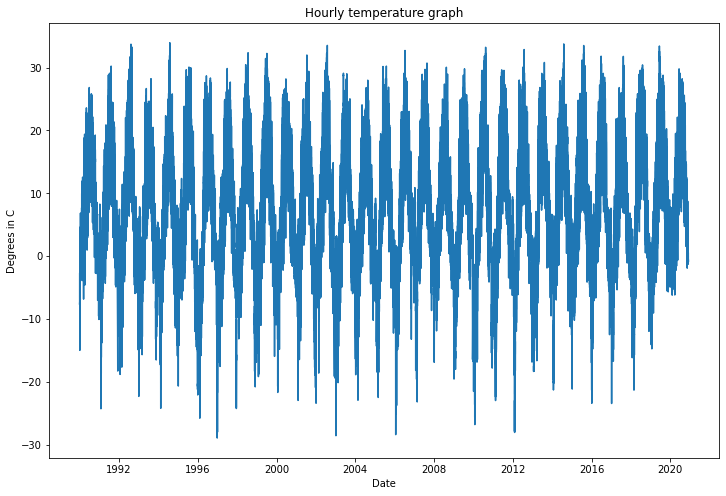

In [13]:
plt.figure(figsize=(12, 8))
plt.plot('dt', 'temp', data=d)
plt.title('Hourly temperature graph')
plt.ylabel('Degrees in C')
plt.xlabel('Date')
plt.show()

## Hourly data plots

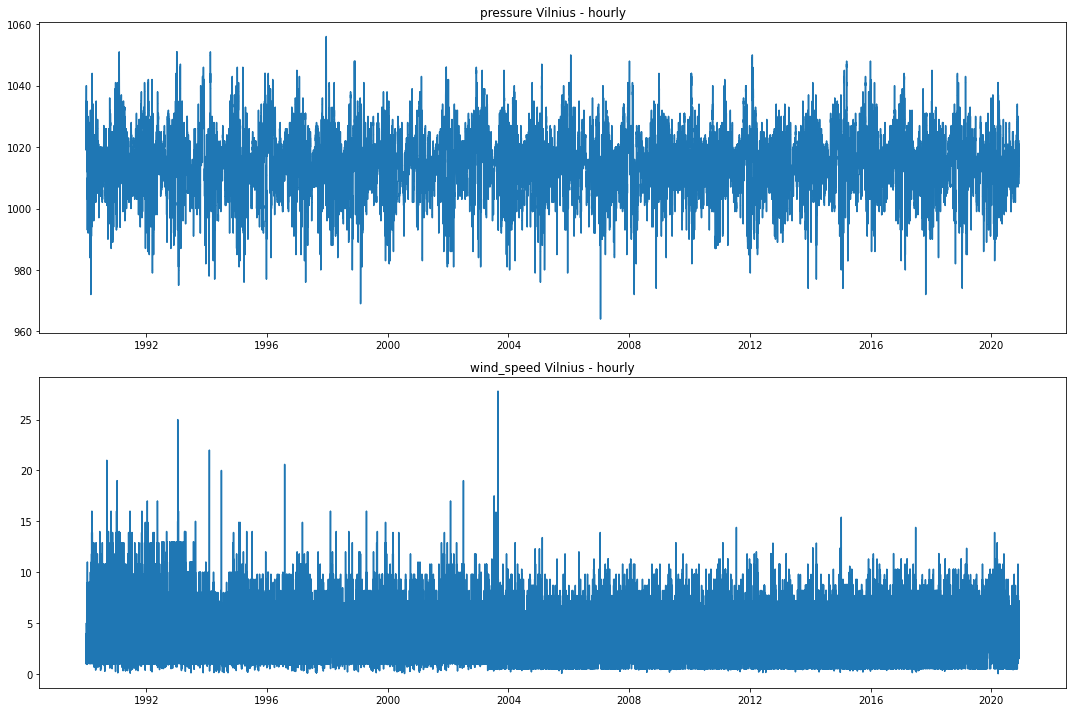

In [14]:
plot_features = d[features]
plot_features.index = d.dt

fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(['pressure', 'wind_speed']):
    axes[i % 2].plot(plot_features[feature])
    axes[i % 2].set_title(f'{feature} Vilnius - hourly')
        
plt.tight_layout()

plt.show()

## Daily data 

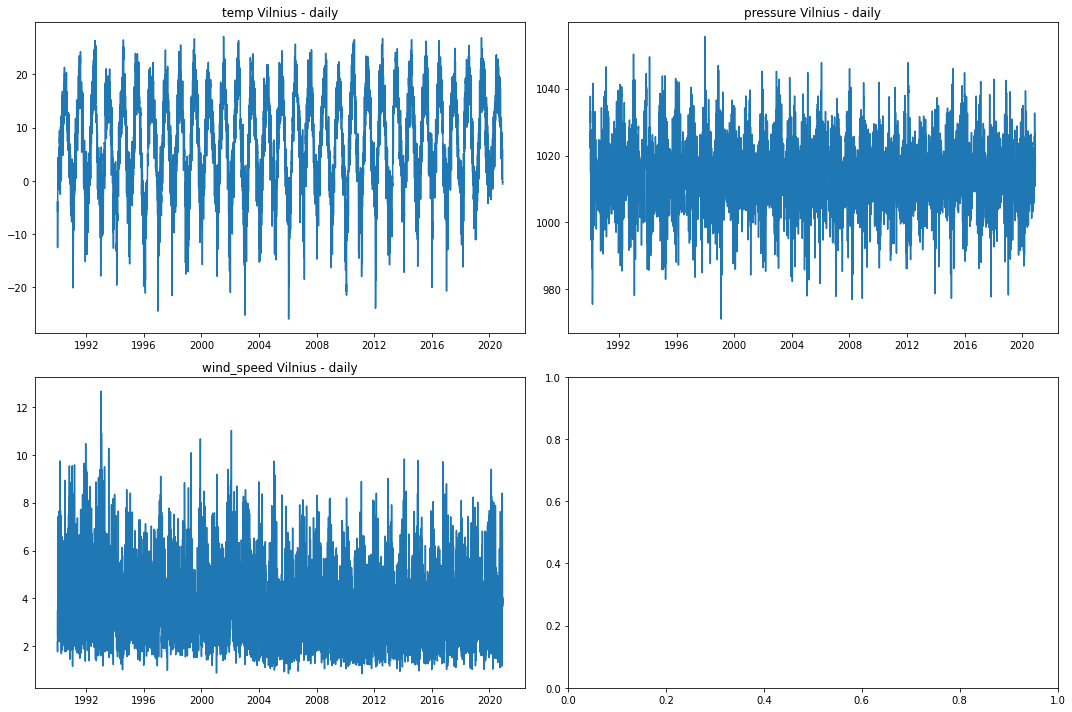

In [15]:
plot_features = d.groupby('date')[features].mean()

fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} Vilnius - daily')
        
plt.tight_layout()

plt.show()

## Heatmaps

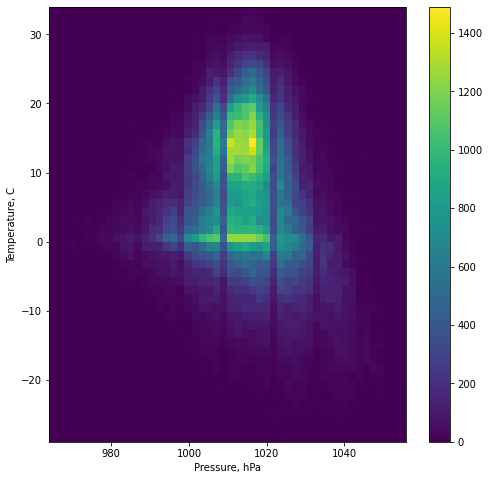

In [16]:
plt.figure(figsize=(8, 8))
plt.hist2d(d['pressure'], d['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Pressure, hPa')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

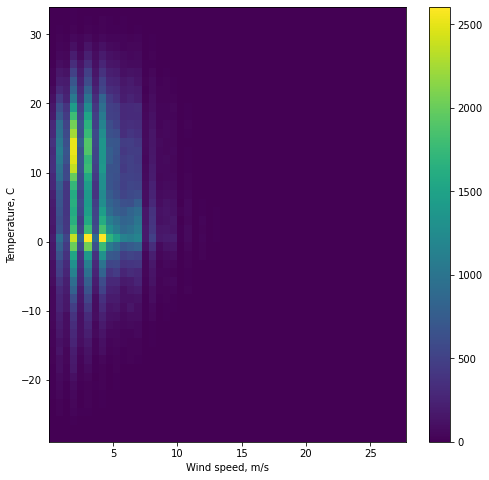

In [17]:
plt.figure(figsize=(8, 8))
plt.hist2d(d['wind_speed'], d['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Wind speed, m/s')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

# Feature engineering

In [18]:
# Extracting the hour of day
d['hour'] = [x.hour for x in d['dt']]

# Extracting the month of the year 
d['month'] = [x.month for x in d['dt']]

<AxesSubplot:title={'center':'temp'}, xlabel='hour'>

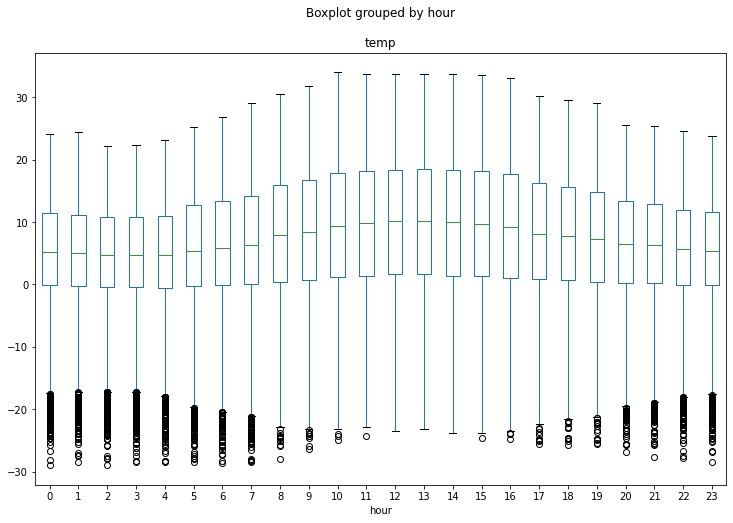

In [19]:
d.boxplot('temp', by='hour', figsize=(12, 8), grid=False)

<AxesSubplot:title={'center':'temp'}, xlabel='month'>

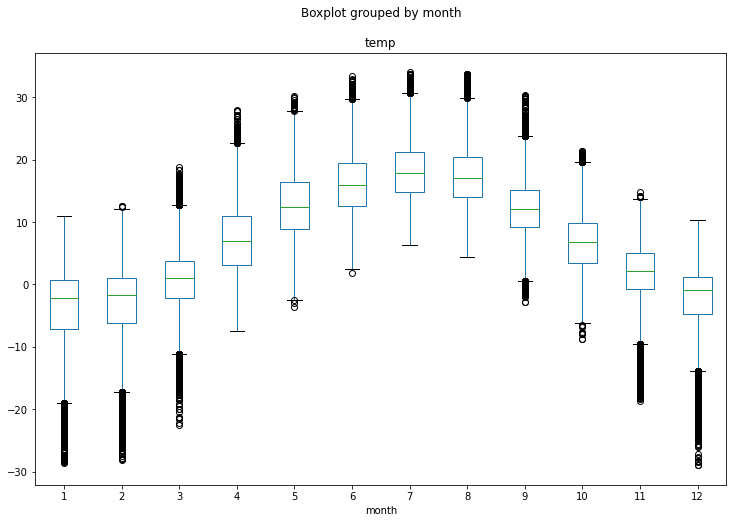

In [20]:
d.boxplot('temp', by='month', figsize=(12, 8), grid=False)

In [21]:
# Creating the cyclical daily feature 
d['day_cos'] = [np.cos(x * (2 * np.pi / 24)) for x in d['hour']]
d['day_sin'] = [np.sin(x * (2 * np.pi / 24)) for x in d['hour']]

In [22]:
dsin = d[['dt', 'temp', 'hour', 'day_sin', 'day_cos']].head(25).copy()
dsin['day_sin'] = [round(x, 3) for x in dsin['day_sin']]
dsin['day_cos'] = [round(x, 3) for x in dsin['day_cos']]

dsin

,dt,temp,hour,day_sin,day_cos
0,1990-01-01 00:00:00,-7.52,0,0.000,1.000
1,1990-01-01 01:00:00,-7.56,1,0.259,0.966
2,1990-01-01 02:00:00,-7.67,2,0.500,0.866
3,1990-01-01 03:00:00,-7.74,3,0.707,0.707
4,1990-01-01 04:00:00,-7.66,4,0.866,0.500
5,1990-01-01 05:00:00,-7.08,5,0.966,0.259
6,1990-01-01 06:00:00,-7.01,6,1.000,0.000
7,1990-01-01 07:00:00,-6.93,7,0.966,-0.259
8,1990-01-01 08:00:00,-6.32,8,0.866,-0.500
9,1990-01-01 09:00:00,-6.07,9,0.707,-0.707


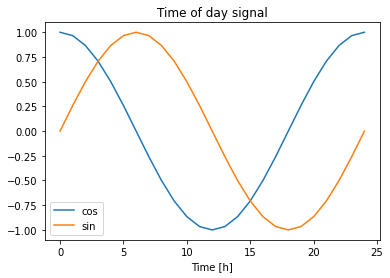

In [23]:
# Ploting the first 25 hours 
plt.plot(np.array(d['day_cos'])[:25], label='cos')
plt.plot(np.array(d['day_sin'])[:25], label='sin')
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.legend()
plt.show()

In [24]:
# Extracting the timestamp from the datetime object 
d['timestamp'] = [x.timestamp() for x in d['dt']]

# Seconds in day 
s = 24 * 60 * 60 

# Seconds in year 
year = (365.25) * s

d['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in d['timestamp']]
d['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in d['timestamp']]

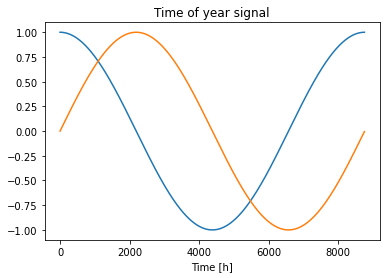

In [25]:
# Ploting the first year
plt.plot(np.array(d['month_cos'])[:24 * 365])
plt.plot(np.array(d['month_sin'])[:24 * 365])
plt.xlabel('Time [h]')
plt.title('Time of year signal')
plt.show()

# Single step forecast

## Hyper parameters

In [26]:
# Number of lags (hours back) to use for models
lag = 48

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

# The features used in the modeling 
features_final = ['temp', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'pressure', 'wind_speed']

## Creating the matrices for training

In [27]:
d[features_final].head(10)

,temp,day_cos,day_sin,month_sin,month_cos,pressure,wind_speed
0,-7.52,1.000000e+00,0.000000,-4.898587e-15,1.000000,1032,2.00
1,-7.56,9.659258e-01,0.258819,7.167676e-04,1.000000,1032,2.00
2,-7.67,8.660254e-01,0.500000,1.433535e-03,0.999999,1028,2.08
3,-7.74,7.071068e-01,0.707107,2.150301e-03,0.999998,1028,2.18
4,-7.66,5.000000e-01,0.866025,2.867067e-03,0.999996,1028,2.12
5,-7.08,2.588190e-01,0.965926,3.583831e-03,0.999994,1030,2.00
6,-7.01,6.123234e-17,1.000000,4.300593e-03,0.999991,1030,2.00
7,-6.93,-2.588190e-01,0.965926,5.017353e-03,0.999987,1030,2.00
8,-6.32,-5.000000e-01,0.866025,5.734110e-03,0.999984,1026,2.22
9,-6.07,-7.071068e-01,0.707107,6.450864e-03,0.999979,1026,2.23


In [28]:
# Subseting only the needed columns 
ts = d[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

In [29]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [30]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [31]:
print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (243863, 48, 7)
Shape of the target data: (243863, 1)
Shape of validation data: (27096, 48, 7)
Shape of the validation target data: (27096, 1)


# Defining the model 

In [32]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [33]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [34]:
model.model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 7)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                720       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.train()

Epoch 1/20
477/477 [==============================] - 10s 21ms/step - loss: 0.2691 - val_loss: 0.1387
Epoch 2/20
477/477 [==============================] - 10s 22ms/step - loss: 0.1213 - val_loss: 0.0986
Epoch 3/20
477/477 [==============================] - 10s 21ms/step - loss: 0.1001 - val_loss: 0.0804
Epoch 4/20
477/477 [==============================] - 10s 21ms/step - loss: 0.0866 - val_loss: 0.0792
Epoch 5/20
477/477 [==============================] - 10s 20ms/step - loss: 0.0779 - val_loss: 0.0668
Epoch 6/20
477/477 [==============================] - 10s 20ms/step - loss: 0.0735 - val_loss: 0.0715
Epoch 7/20
477/477 [==============================] - 9s 20ms/step - loss: 0.0717 - val_loss: 0.0575
Epoch 8/20
477/477 [==============================] - 10s 20ms/step - loss: 0.0675 - val_loss: 0.0666
Epoch 9/20
477/477 [==============================] - 9s 19ms/step - loss: 0.0675 - val_loss: 0.0535
Epoch 10/20
477/477 [==============================] - 9s 18ms/step - loss: 0.0642 -

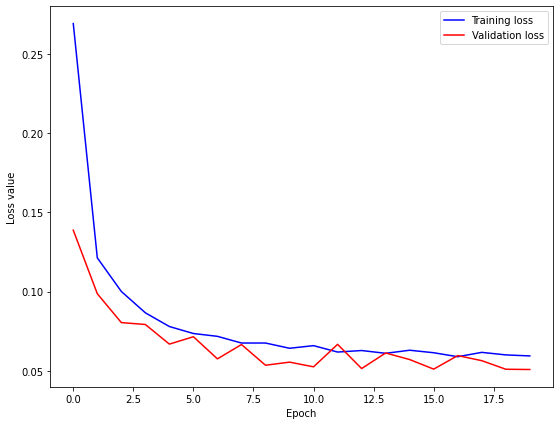

In [36]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [37]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

In [53]:
# Creating the frame to store both predictions
days = d['dt'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

In [54]:
pivoted.tail(10)

,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,res,res_abs
day,,,,,,
2020-11-30 14:00:00,-0.793414,-0.791943,-0.523923,-0.51,0.013923,0.013923
2020-11-30 15:00:00,-0.823321,-0.797228,-0.806867,-0.56,0.246867,0.246867
2020-11-30 16:00:00,-0.825288,-0.798285,-0.825478,-0.57,0.255478,0.255478
2020-11-30 17:00:00,-0.825989,-0.816253,-0.832110,-0.74,0.092110,0.092110
2020-11-30 18:00:00,-0.841069,-0.835279,-0.974783,-0.92,0.054783,0.054783
2020-11-30 19:00:00,-0.861765,-0.836336,-1.170583,-0.93,0.240583,0.240583
2020-11-30 20:00:00,-0.865690,-0.835279,-1.207718,-0.92,0.287718,0.287718
2020-11-30 21:00:00,-0.868307,-0.827880,-1.232481,-0.85,0.382481,0.382481
2020-11-30 22:00:00,-0.869778,-0.827880,-1.246393,-0.85,0.396393,0.396393


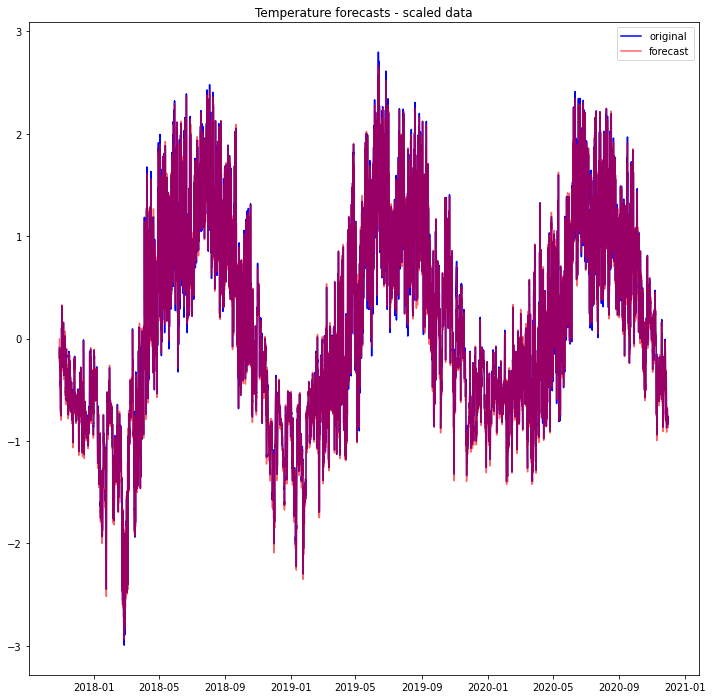

In [67]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - scaled data')
plt.legend()
plt.show()

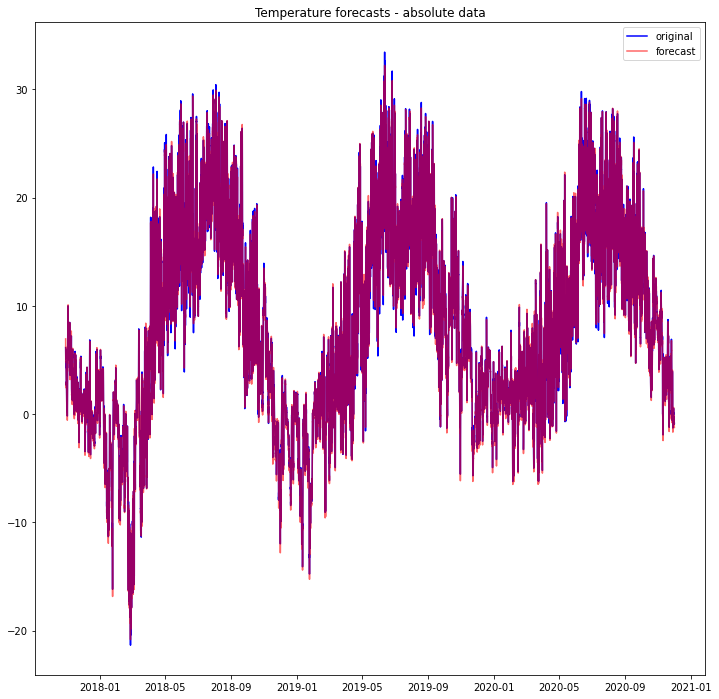

In [73]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - absolute data')
plt.legend()
plt.show()

In [43]:
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

In [50]:
pivoted.tail(10)

,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,res,res_abs
day,,,,,,
2020-11-30 14:00:00,-0.793414,-0.791943,-0.523923,-0.51,0.013923,0.013923
2020-11-30 15:00:00,-0.823321,-0.797228,-0.806867,-0.56,0.246867,0.246867
2020-11-30 16:00:00,-0.825288,-0.798285,-0.825478,-0.57,0.255478,0.255478
2020-11-30 17:00:00,-0.825989,-0.816253,-0.832110,-0.74,0.092110,0.092110
2020-11-30 18:00:00,-0.841069,-0.835279,-0.974783,-0.92,0.054783,0.054783
2020-11-30 19:00:00,-0.861765,-0.836336,-1.170583,-0.93,0.240583,0.240583
2020-11-30 20:00:00,-0.865690,-0.835279,-1.207718,-0.92,0.287718,0.287718
2020-11-30 21:00:00,-0.868307,-0.827880,-1.232481,-0.85,0.382481,0.382481
2020-11-30 22:00:00,-0.869778,-0.827880,-1.246393,-0.85,0.396393,0.396393


In [74]:
print(f"Average absolute mean error: {round(pivoted['res_abs'].sum() / pivoted.shape[0], 2)} C")

Average absolute mean error: 0.48 C


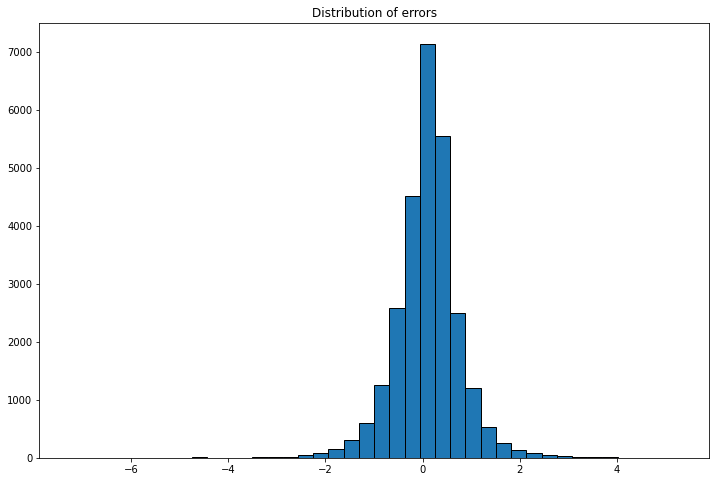

In [75]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res, bins=40, edgecolor='black')
plt.title('Distribution of errors')
plt.show()

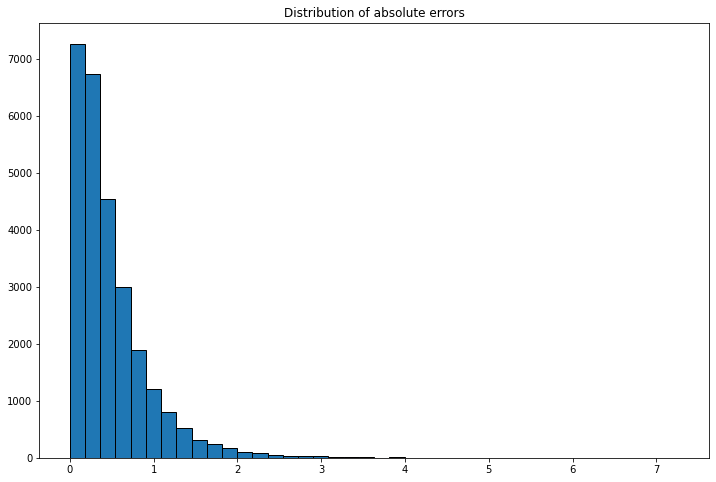

In [76]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res_abs, bins=40, edgecolor='black')
plt.title('Distribution of absolute errors')
plt.show()

In [47]:
pivoted.res_abs.describe()

count    27096.000000
mean         0.480791
std          0.467825
min          0.000008
25%          0.168428
50%          0.348462
75%          0.645027
max          7.263866
Name: res_abs, dtype: float64

# Sequence prediction 

In [101]:
# Number of lags (hours back) to use for models
lag = 168

# Steps ahead to forecast 
n_ahead = 24

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

In [102]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [103]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (243734, 168, 7)
Shape of the target data: (243734, 24)
Shape of validation data: (27082, 168, 7)
Shape of the validation target data: (27082, 24)


In [104]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [105]:
model.model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 168, 7)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                720       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                264       
Total params: 984
Trainable params: 984
Non-trainable params: 0
_________________________________________________________________


In [106]:
history = model.train()

Epoch 1/20
477/477 [==============================] - 30s 62ms/step - loss: 0.4952 - val_loss: 0.2761
Epoch 2/20
477/477 [==============================] - 30s 63ms/step - loss: 0.2526 - val_loss: 0.2215
Epoch 3/20
477/477 [==============================] - 27s 56ms/step - loss: 0.2167 - val_loss: 0.2071
Epoch 4/20
477/477 [==============================] - 24s 51ms/step - loss: 0.2070 - val_loss: 0.2002
Epoch 5/20
477/477 [==============================] - 20s 43ms/step - loss: 0.2010 - val_loss: 0.1960
Epoch 6/20
477/477 [==============================] - 19s 41ms/step - loss: 0.1971 - val_loss: 0.1929
Epoch 7/20
477/477 [==============================] - 19s 40ms/step - loss: 0.1943 - val_loss: 0.1903
Epoch 8/20
477/477 [==============================] - 19s 40ms/step - loss: 0.1921 - val_loss: 0.1884
Epoch 9/20
477/477 [==============================] - 19s 40ms/step - loss: 0.1902 - val_loss: 0.1868
Epoch 10/20
477/477 [==============================] - 19s 40ms/step - loss: 0.188

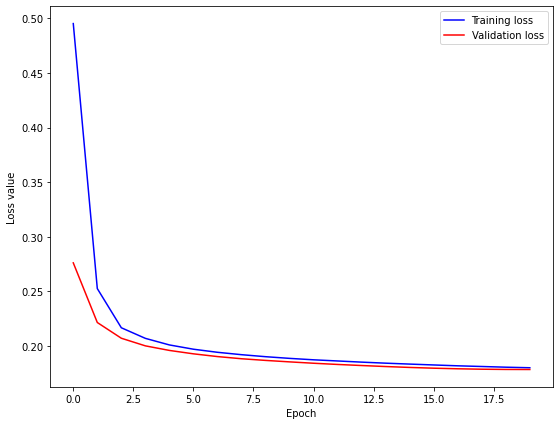

In [107]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [108]:
# Forecasting on all the samples in the validation set 
forecast = model.predict(Xval)

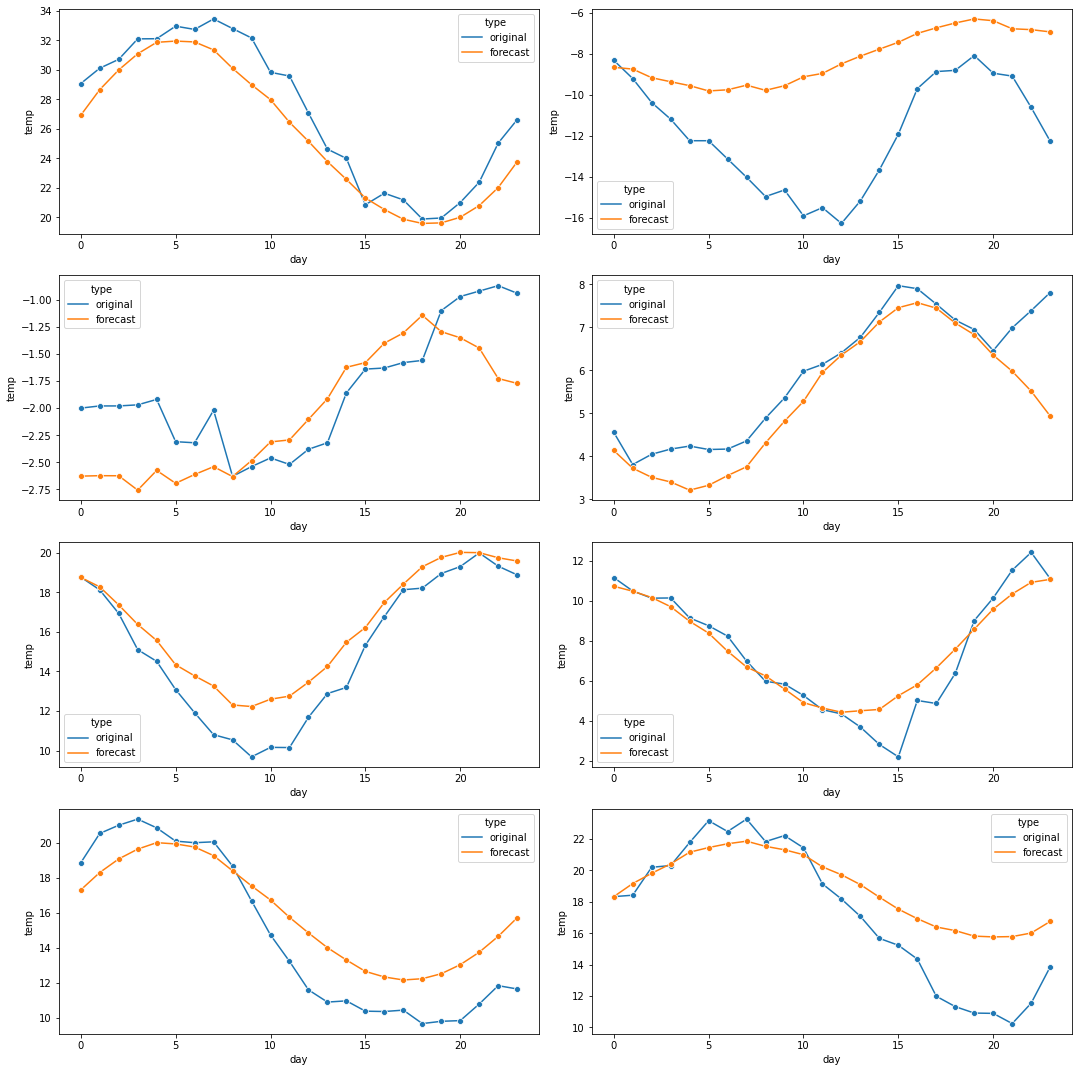

In [146]:
fig, axes = plt.subplots(
    nrows=4, 
    ncols=2, 
    figsize=(15, 15), 
    facecolor="w", 
    edgecolor="k"
)

indexes = random.sample(range(len(forecast)), 8)

for i, index in enumerate(indexes):
    
    yhat = forecast[index]
    y = Yval[index]

    frame = pd.concat([
        pd.DataFrame({'day': range(len(y)), 'temp': y, 'type': 'original'}),
        pd.DataFrame({'day': range(len(y)), 'temp': yhat, 'type': 'forecast'})
    ])
    
    frame=frame.reset_index(drop = True)    frame['temp'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]
    
    sns.lineplot(x='day', y='temp', ax = axes[i // 2, i % 2], data=frame, hue='type', marker='o')
        
plt.tight_layout()

plt.show()

In [110]:
# Calculating the total average absolute error 
error = 0 
n = 0
residuals = []

for i in range(Yval.shape[0]):
    true = Yval[i]
    hat = forecast[i]
    n += len(true)
    
    true = np.asarray([(x * train_std['temp']) + train_mean['temp'] for x in true])
    hat = np.asarray([(x * train_std['temp']) + train_mean['temp'] for x in hat])
    
    residual = true - hat
    residuals.append(residual)
    
    error += np.sum([abs(x) for x in true - hat]) 

print(f'Final average absolute error: {round(error / n, 2)} C')

Final average absolute error: 1.69 C


In [111]:
# Flattening the list of arrays of residuals
residuals = np.asarray(residuals).flatten().tolist()
abs_residuals = [abs(x) for x in residuals]

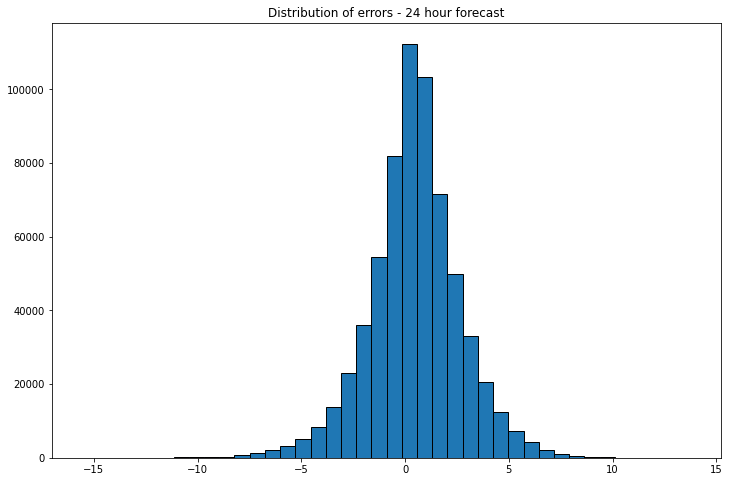

In [112]:
plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=40, edgecolor='black')
plt.title('Distribution of errors - 24 hour forecast')
plt.show()

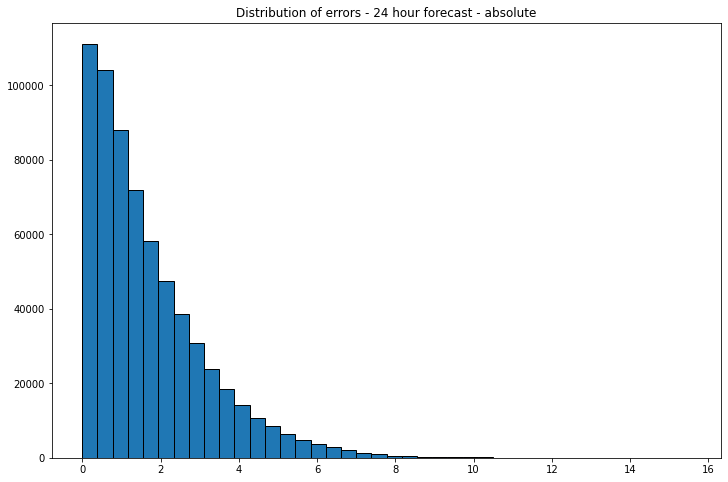

In [113]:
plt.figure(figsize=(12, 8))
plt.hist(abs_residuals, bins=40, edgecolor='black')
plt.title('Distribution of errors - 24 hour forecast - absolute')
plt.show()

In [114]:
print(f"Median absoulte error: {round(np.median(abs_residuals), 2)} C")

Median absoulte error: 1.27 C
